In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

In [22]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
clust_df = pd.read_csv('/Users/gabrieltaylor/Python/STAT542/STAT542/gabet/clust_df.csv', index_col = 0)

# Supervised Task

In [24]:
sup_df = clust_df.join(df['nutrition-score-fr_100g']).dropna()

In [25]:
sup_df

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,nutrition-score-fr_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,0.0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,8.0
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,8.0
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,18.0
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,14.0
...,...,...,...,...,...,...,...,...,...
355083,almonds,-0.815304,1.740633,-0.376465,1.090071,0.249769,-0.191702,4,0.0
355269,shrimp salt,-0.966496,-0.770789,-0.620892,0.202016,-0.795579,-0.700412,6,0.0
355474,beef sugar salt tomato-paste garlic spices mon...,-0.843825,-0.770789,-0.422573,1.244187,0.230953,0.561472,6,19.0
355525,eggs,-0.956188,-0.770789,-0.604227,0.314100,-0.267678,-0.262356,6,0.0


## Is there a clear ranking of nutrition scores by cluster?

In [26]:
ranks = pd.DataFrame(sup_df.groupby('clust').mean()['nutrition-score-fr_100g']).sort_values('nutrition-score-fr_100g')
ranks.sort_values("nutrition-score-fr_100g")

,nutrition-score-fr_100g
clust,
5,0.334542
1,1.170208
6,5.114522
4,8.904300
3,13.166827
2,20.422587
0,21.349800


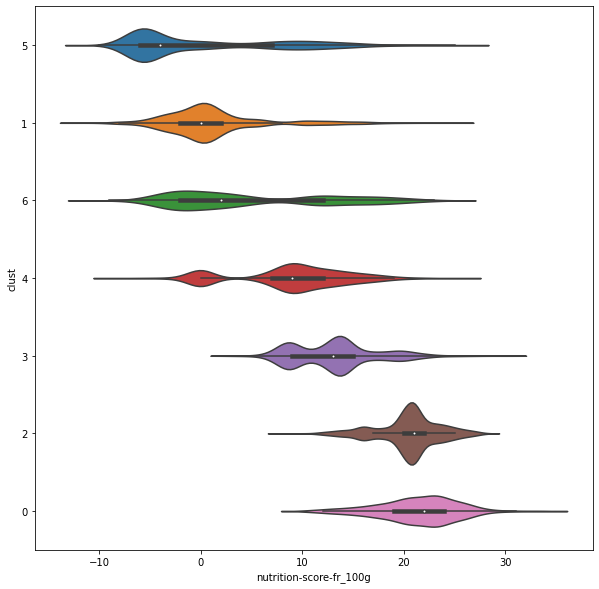

In [28]:
plt.figure(figsize = (10, 10))
sns.violinplot(data=sup_df, x = 'nutrition-score-fr_100g', y="clust", orient="h", order = [5, 1, 6, 4, 3, 2, 0])
plt.show()

Yes, there is clearly a ranking of nutrition scores by cluster.

## How well can clusters alone predict nutrition score?

First, we will make this a supremely easy task by splitting the nutrition score into binary categories. 

In [29]:
sup_df['nutrition-score-fr_100g'].describe()

count    12222.000000
mean         7.449435
std          9.623551
min        -12.000000
25%         -1.000000
50%          6.000000
75%         16.000000
max         34.000000
Name: nutrition-score-fr_100g, dtype: float64

In [30]:
sup_df['new_score'] = list(map(lambda x : 1 if x > 6 else 0, sup_df['nutrition-score-fr_100g']))
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,nutrition-score-fr_100g,new_score
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,0.0,0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,8.0,1
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,8.0,1
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,18.0,1
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,14.0,1


In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
X = sup_df['clust']
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [33]:
model = XGBClassifier()
model.fit(X_train.values.reshape(-1, 1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred = model.predict(X_test.values.reshape(-1, 1))
accuracy_score(y_test, y_pred)

0.8638036809815951

85% accuracy is not bad. Now, how can we use the clusters and text information to predict nutrition score?

## Cluster Prevalence

In [44]:
all_words = [i for ing in sup_df['ingredients_text'] for i in ing.split()]
most_common_words = dict(Counter(all_words).most_common(1000))
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [45]:
tot_word_counts = dict(Counter(all_words))

In [46]:
### TD IDF
N = clust_df.shape[0]

### TF-IDF For Cluster Prevalence (Just like in the unsupervised notebook)

In [68]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common())
    
    ### TF IDF To Obtain True Cluster Prevelance 
    for key in clust_word_counts.keys():
        clust_word_counts[key] = clust_word_counts[key] * np.log(N / tot_word_counts[key])
    
    return clust_word_counts

In [48]:
clust_words = sup_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)

## Let's take the top 100 most common ingredients as our predictors, but input the TD-IDF scores from the cluster corresponding to that row

First, lets get the 100 most common ingredients

In [49]:
all_common = list(most_common_words.keys())
reduced_words = [w for w in all_common if w not in better_words]
top_100 = reduced_words[:100]

In [50]:
TD_IDF_key = pd.DataFrame(clust_words).reset_index()
TD_IDF_key.columns = ['cluster', 'ingredient', 'td-idf']

In [51]:
TD_IDF_key[TD_IDF_key.cluster == 0]

,cluster,ingredient,td-idf
0,0,cocoa-butter,1339.437765
1,0,soy-lecithin,1082.423821
2,0,chocolate-liquor,968.966839
3,0,vanilla,826.711398
4,0,milk,519.763035
...,...,...,...
831,0,viande-de-porc,NaN
832,0,antioxydant-:-ascorbate-de-sodium,NaN
833,0,conservateur-:-nitrite-de-sodium,NaN
834,0,extrait-de-levure,NaN


Iterate through sup_df, and grab the TD-IDF corresponding to each ingredient in the assigned cluster. If an ingredient is not in the top 100 words, then we skip it.

In [52]:
#zero_mat = np.zeros((sup_df.shape[0], 100))
our_dtm = pd.DataFrame(columns = top_100)

In [53]:
our_dtm

,enzymes,citric-acid,niacin,corn-syrup,folic-acid,riboflavin,pasteurized-milk,cheese-culture,milk,soy-lecithin,...,sodium-bicarbonate,lactic-acid,to-retain-moisture,annatto-color,tomato-juice,yellow-6,garlic-powder,spinach,sodium-diacetate,preservative


### This is really inefficient

In [54]:
for ingredients, cluster in zip(sup_df['ingredients_text'], sup_df['clust']):
    
    ### Grab Cluster
    clust_key = TD_IDF_key[TD_IDF_key.cluster == cluster]
    
    ### List of ingredients
    ing_list = ingredients.split()
    
    ### Grab values from key
    new_row = [clust_key[clust_key.ingredient == i]['td-idf'].item() if i in ing_list else 0 for i in top_100]
    
    our_dtm = our_dtm.append({k: v for k, v in zip(top_100, new_row)}, ignore_index = True)

In [ ]:
# our_dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")

In [55]:
our_dtm.head()

,enzymes,citric-acid,niacin,corn-syrup,folic-acid,riboflavin,pasteurized-milk,cheese-culture,milk,soy-lecithin,...,sodium-bicarbonate,lactic-acid,to-retain-moisture,annatto-color,tomato-juice,yellow-6,garlic-powder,spinach,sodium-diacetate,preservative
0,0.0000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.6251,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0,2010.026967,0.0,1953.24123,1980.866469,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X = our_dtm
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [57]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8969325153374234

## Now let's do regression

In [59]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [60]:
X = our_dtm
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [61]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.335161516602214

## In case using cluster info is cheating, lets try regular old count vectorization

In [63]:
new_dtm = pd.DataFrame(columns = top_100)

In [64]:
for ingredients in sup_df['ingredients_text']:
    
    ### List of ingredients
    ing_list = ingredients.split()
    
    ### Grab values from key
    new_row = [1.0 if i in ing_list else 0.0 for i in top_100]
    
    new_dtm = new_dtm.append({k: v for k, v in zip(top_100, new_row)}, ignore_index = True)

In [65]:
new_dtm.head()

,enzymes,citric-acid,niacin,corn-syrup,folic-acid,riboflavin,pasteurized-milk,cheese-culture,milk,soy-lecithin,...,sodium-bicarbonate,lactic-acid,to-retain-moisture,annatto-color,tomato-juice,yellow-6,garlic-powder,spinach,sodium-diacetate,preservative
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification

In [66]:
X = new_dtm
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [67]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8711656441717791

## Regression

In [69]:
X = new_dtm
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [70]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.777112869860696